# "Buidling an MNIST Classifier from scratch with Pytorch"
> "A first post on making my way through fastbook"
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [ml]
- image: ../images/mnist_example.png
- hide: false
- showtags: true
- search_exclude: false

I've been following Jermey Howard's and Sylvain Gugger's excellent preprint [fastbook](https://github.com/fastai/fastbook), their soon to be released book on deep learning and the new fastai2 API. While I've been practicing machine learning for land cover segmentation for a while now, I wanted a deeper understanding of the architectures I've been using. Chapter 4 provided an excellent walkthrough of building and evaluating a linear classifier and then a simple 3 layer neural network classifier of 3s and 7s. The final challenge after this chapter tasks the reader with the following:

> ### Further research

> 1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
> 1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just threes and sevens). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

[Source: Under the hood: training a digit classifier](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

After going through the Ch. 4 tutorial on building a binary classifier from scratch, I decided to jump straight to Challenge number 2 and complete it with functions. Below is the resulting code in case it's useful for anyone. Big thanks to Jeremy and Sebastian for their generosity in developing the book and fastai course and thanks to the pytorch community for taking the time to answer community questions [like this one](https://discuss.pytorch.org/t/mnist-dataset-why-is-my-loss-so-high-beginner/62670), which helped me troubleshoot my own issues.

### Programming environment setup

I used the [nvidia-data-science-stack 2.2](https://github.com/NVIDIA/data-science-stack) to build a conda environment. This is a nifty tool that makes it easy to set up gpu dependencies. If you build a docker container, you don't need to mess around with installing nvidia drivers at all. Then I did development installs of fastai2 and fastcore (you can find them on github). You can run this whole tutorial on the cpu, it will take minutes rather than seconds compared to a gpu.

In [1]:
from fastai2.vision.all import *

matplotlib.rc('image', cmap='Greys')

data_path = untar_data(URLs.MNIST)

data_path.ls()

(#2) [Path('/home/rave/.fastai/data/mnist_png/training'),Path('/home/rave/.fastai/data/mnist_png/testing')]

In [2]:
(data_path/"training").ls()

(#10) [Path('/home/rave/.fastai/data/mnist_png/training/5'),Path('/home/rave/.fastai/data/mnist_png/training/9'),Path('/home/rave/.fastai/data/mnist_png/training/6'),Path('/home/rave/.fastai/data/mnist_png/training/7'),Path('/home/rave/.fastai/data/mnist_png/training/2'),Path('/home/rave/.fastai/data/mnist_png/training/8'),Path('/home/rave/.fastai/data/mnist_png/training/4'),Path('/home/rave/.fastai/data/mnist_png/training/1'),Path('/home/rave/.fastai/data/mnist_png/training/3'),Path('/home/rave/.fastai/data/mnist_png/training/0')]

### First we load in the data

In [3]:
def load_x_y(folder):
    numtensors = []
    labellists = []
    for num in range(9):
        num_paths = (data_path/folder/f'{num}').ls().sorted()
        tensors = [tensor(Image.open(n)) for n in num_paths]
        num_tensor = torch.stack(tensors).float()/255.0
        numtensors.append(num_tensor)
        labellists.extend([num]*len(num_paths))

    train_x = torch.cat(numtensors).view(-1, 28*28) 
    # list of vectors where each vector is an image. list is ordered from 0 samples to 9 samples

    train_y = tensor(labellists)
    
    return train_x, train_y

train_x, train_y = load_x_y("training")
test_x, test_y = load_x_y("testing")
train_dl = DataLoader(list(zip(train_x, train_y)), batch_size=256)
test_dl = DataLoader(list(zip(test_x, test_y)), batch_size=256)

### Each image is reshaped in the `load_x_y` func to be a vector, so we need to reshaped it with `.view` to plot it.

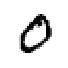

In [4]:
show_image(train_x[0].view(28,28))

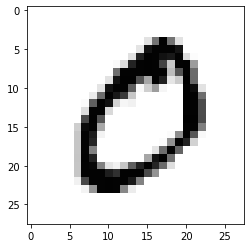

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_x[0].view(28,28))
plt.savefig("/home/rave/site/images/mnist_example.png")

### Below are the components of our network and training plan.

In [15]:
def train_model(model, lr=1, epochs = 20):
    for i in range(epochs): # step 6 define a stopping condition, the number of epochs in this case.
        loss = train_epoch( model, lr) 
        print("Loss for all MNIST classes Train: ", loss)
        print("Total Test Accuracy For all MNIST classes: ", validate_epoch(model)) # step 5 calculate accuracy

def validate_epoch(model):
    accs = [batch_accuracy(model(x_batch), y_batch) for x_batch, y_batch in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

def batch_accuracy(prediction_batch, label_batch):
    prob_scores = prediction_batch.softmax(1) # gets final activations into range of 0,1 so that all add up to 1
    accuracy = get_num_correct(prob_scores, label_batch) / float( label_batch.size(0) ) # sum the right predictions, divide by total number of isntances
    return accuracy

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().float() # labels needs to be a 1d tensor for this comparison for broadcasting
        
def train_epoch(model, lr):
    losses = []
    for xs, ys in train_dl: # step 4 continue another forward pass and repeat for another epoch
        # calcualtes the gradient with respect to weight and bias params at each layer of the model
        loss = calc_grad(xs, ys, model)
        for p in params:
            # modifies params in place, step 3 update the params (this  uses the backprop calculated gradient)
            p.data = p.data - p.grad * lr
            p.grad.zero_()
        losses.append(loss.detach())
    return torch.stack(losses).mean()

# step 2 calculate gradient
def calc_grad(x_batch, y_batch, model, loss_func=F.cross_entropy):
    predictions = model(x_batch)
    loss = loss_func(predictions, y_batch)
    loss.backward()
    return loss
        
def linear_layer(xb):
    return xb@ws + bs

### First step is to initialize random weights

In [16]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

ws = init_params((28*28,10))

bs = init_params(10)

params = ws, bs

lr = 1.0

In [17]:
validate_epoch(linear_layer)

0.1255

In [18]:
lr = 1.
params = ws, bs
train_epoch(linear_layer, lr)
validate_epoch(linear_layer)

0.1684

### Our accuracy improves! We can now train a full model with multiple epochs. 

In [19]:
train_model(linear_layer, lr=1)

Loss for all MNIST classes Train:  tensor(0.6126)
Total Test Accuracy For all MNIST classes:  0.2942
Loss for all MNIST classes Train:  tensor(0.4020)
Total Test Accuracy For all MNIST classes:  0.3543
Loss for all MNIST classes Train:  tensor(0.3152)
Total Test Accuracy For all MNIST classes:  0.3799
Loss for all MNIST classes Train:  tensor(0.2817)
Total Test Accuracy For all MNIST classes:  0.3963
Loss for all MNIST classes Train:  tensor(0.2605)
Total Test Accuracy For all MNIST classes:  0.4109
Loss for all MNIST classes Train:  tensor(0.2467)
Total Test Accuracy For all MNIST classes:  0.4248
Loss for all MNIST classes Train:  tensor(0.2371)
Total Test Accuracy For all MNIST classes:  0.4374
Loss for all MNIST classes Train:  tensor(0.2295)
Total Test Accuracy For all MNIST classes:  0.4455
Loss for all MNIST classes Train:  tensor(0.2229)
Total Test Accuracy For all MNIST classes:  0.454
Loss for all MNIST classes Train:  tensor(0.2170)
Total Test Accuracy For all MNIST classes:

### Much of the above code can be compressed down to the following code chunk using fastai, plus I'm testing a simple 2 (3?) layer net instead of a simpler linear model.

In [20]:
dls = DataLoaders(train_dl, test_dl)
simple_net = nn.Sequential(
    nn.Linear(28*28,30), # 28*28 is shape of image input
    nn.ReLU(),
    nn.Linear(30, 10) # 10 classes, 10 ending neurons
)
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=batch_accuracy)

learn.fit(20, .01)

epoch,train_loss,valid_loss,batch_accuracy,time
0,1.477771,2.973853,0.108331,00:00
1,0.943950,2.823479,0.109776,00:00
2,0.689013,2.432964,0.175064,00:00
3,0.551735,2.100434,0.299855,00:00
4,0.472151,1.843670,0.385163,00:00
5,0.420042,1.648977,0.432432,00:00
6,0.383341,1.498606,0.476365,00:00
7,0.356098,1.379916,0.515071,00:00
8,0.335129,1.284503,0.550328,00:00
9,0.318766,1.206264,0.577021,00:00


### Adding a relu and another linear layer gets us an increase in accuracy from about 50% to 70% with the same number of epochs (try training for longer and with different numbers of neurons in the first linear layer, which makes a bigger difference)?

Some issues I ran into include:

* multilabel softmax loss wasn't working, not sure why it wasn't the right loss function, but cross entropy worked after I set the weights and bias shapes so that the last dimension was 10 for the 10 "probability" scores for each digit.
* I also had to find broadcasting errors. My accuracy was increasing above 1 until I found that the y_labels in `batch_accuracy` need to be a 1D tensor when doing comparisons with argmax. I had called `unsqueeze` in `load_x_y` on these label arrays which added an extra dimension that caused the broadcasting issue.
* I kept running into cases where my loss was decreasing but my accuracy stayed the same, probably having to do with messy jupyter notebook state.

![](../images/thats_all_folks.gif)